### Imports

In [1]:
import sys
import os
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
src_dir = os.path.join(project_root, 'src')
sys.path.append(src_dir)
import spectra as spectra
from utils.plotters import visualize_geometry, visualize_signal

import numpy as np
import jax
import jax.numpy as jnp
import optax
import chex
import matplotlib.pyplot as plt
import e3nn_jax as e3nn

import plotly.graph_objects as go
from scipy.stats import special_ortho_group
from typing import Tuple


### Geometries to test with

In [2]:
lmax = 4

original_geometry = jnp.asarray([
    [1, 0, 0],
    [-0.5, jnp.sqrt(3)/2, 0],
    [-0.5, -jnp.sqrt(3)/2, 0]])
original_signal = spectra.sum_of_diracs(original_geometry, lmax=lmax)

visualize_signal(original_signal)

In [3]:
ground_truth_quaternion = jax.numpy.array([np.random.normal() for _ in range(4)])
ground_truth_quaternion = ground_truth_quaternion / jnp.linalg.norm(ground_truth_quaternion)  # normalize to unit quaternion
rotated_signal = original_signal.transform_by_quaternion(ground_truth_quaternion)
visualize_signal(rotated_signal)


/home/gridsan/tphung/pyspectra/venv/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning:

Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.



### Rotation functions

In [4]:
import numpy as np
from scipy.spatial.transform import Rotation
from scipy.optimize import minimize


def spherical_distance(signal1, signal2):
    """
    Calculate distance between two spherical signals
    
    Parameters:
        signal1, signal2: Arrays of SH coefficients
    Returns:
        Distance metric (L2 norm of coefficient differences)
    """
    signal1 = e3nn.to_s2grid(signal1, 30, 29, quadrature="soft")
    signal2 = e3nn.to_s2grid(signal2, 30, 29, quadrature="soft")

    signal1_vectors = signal1.grid_vectors * signal1.grid_values[..., None]
    signal2_vectors = signal2.grid_vectors * signal2.grid_values[..., None]

    signal1_vectors = signal1_vectors.reshape((-1, 3))
    signal2_vectors = signal2_vectors.reshape((-1, 3))
    
    squared_distances = jnp.linalg.norm(signal1_vectors[:, None, :] - signal2_vectors[None, :, :], axis=-1) ** 2
    return jnp.min(squared_distances, axis=-1).mean()


def find_optimal_rotation(signal1: e3nn.SphericalSignal, signal2: e3nn.SphericalSignal, initial_guess: jnp.ndarray = None):
    """
    Find optimal rotation to align source signal with target signal
    
    Parameters:
        signal1: SH coefficients of target signal
        signal2: SH coefficients of signal to be rotated
    Returns:
        Optimal rotation matrix
    """
    if initial_guess is None:
        initial_guess = np.array([np.random.uniform(-1, 1) for _ in range(4)])
        initial_guess = initial_guess / np.linalg.norm(initial_guess)  # normalize to unit quaternion
    
    def objective(quaternion):
        quaternion = jnp.asarray(quaternion)
        rotated_signal1 = signal1.transform_by_quaternion(quaternion)
        return spherical_distance(rotated_signal1, signal2)
    
    def constraint(quaternion):
        return np.linalg.norm(quaternion) - 1.0  # Constraint: ||q|| = 1
    
    result = minimize(objective, initial_guess,
                     method='SLSQP',
                     constraints={'type': 'eq', 'fun': constraint})
    
    return jnp.asarray(result.x)

### Attempt to recover rotation matrix

In [5]:
objective_values = []
min_objective = np.inf
best_quaternion = None
for i in range(100):
    random_quaternion = np.array([np.random.uniform(-1, 1) for _ in range(4)])
    random_quaternion = random_quaternion / np.linalg.norm(random_quaternion)  # normalize to unit quaternion
    random_rotated_signal = original_signal.transform_by_quaternion(random_quaternion)
    objective_value = spherical_distance(random_rotated_signal, rotated_signal)
    objective_values.append(objective_value)
    if objective_value < min_objective:
        min_objective = objective_value
        best_quaternion = random_quaternion

predicted_quaternion = find_optimal_rotation(original_signal, rotated_signal, best_quaternion)

In [6]:
predicted_quaternion

Array([-0.13284026, -0.5080946 ,  0.6346897 , -0.5668883 ], dtype=float32)

In [7]:
ground_truth_quaternion

Array([ 0.2850907 ,  0.24797921,  0.8581196 , -0.3476496 ], dtype=float32)

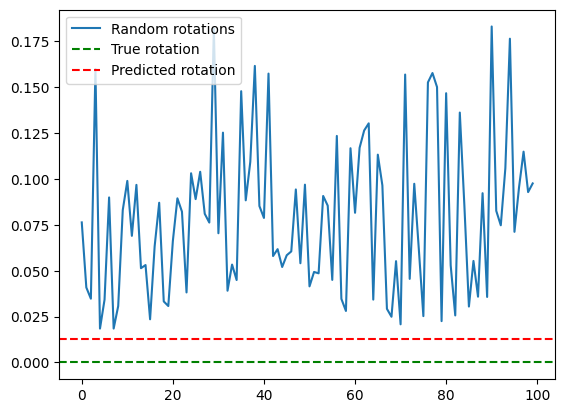

In [8]:
# Calculate objective for random rotations
objective_values = []
for i in range(100):
    random_quaternion = jax.numpy.array([np.random.uniform(-1, 1) for _ in range(4)])
    random_quaternion = random_quaternion / jnp.linalg.norm(random_quaternion)  # normalize to unit quaternion
    random_rotated_signal = original_signal.transform_by_quaternion(random_quaternion)
    objective_value = spherical_distance(random_rotated_signal, rotated_signal)
    objective_values.append(objective_value)

# Calculate objective for predicted rotation
predicted_rotated_signal = original_signal.transform_by_quaternion(predicted_quaternion)
predicted_objective = spherical_distance(predicted_rotated_signal, rotated_signal)

# Calculate objective for true random rotation
true_objective = spherical_distance(rotated_signal, rotated_signal)

# Plot random objectives and predicted objective
plt.plot(objective_values, label='Random rotations')
plt.axhline(y=true_objective, color='g', linestyle='--', label='True rotation')
plt.axhline(y=predicted_objective, color='r', linestyle='--', label='Predicted rotation')
plt.legend()

In [9]:
from tqdm import tqdm

def sample_uniform_quaternion():
    u1, u2, u3 = np.random.uniform(0, 1, 3)
    q0 = np.sqrt(1 - u1) * np.sin(2 * np.pi * u2)
    q1 = np.sqrt(1 - u1) * np.cos(2 * np.pi * u2)
    q2 = np.sqrt(u1) * np.sin(2 * np.pi * u3)
    q3 = np.sqrt(u1) * np.cos(2 * np.pi * u3)
    return np.array([q0, q1, q2, q3])

# Calculate objective for random rotations
objective_values = []
for i in tqdm(range(10000)):
    random_quaternion = sample_uniform_quaternion()
    random_rotated_signal = original_signal.transform_by_quaternion(random_quaternion)
    objective_value = spherical_distance(random_rotated_signal, rotated_signal)
    objective_values.append(objective_value)

100%|██████████| 10000/10000 [04:18<00:00, 38.75it/s]


In [11]:
visualize_signal(original_signal.transform_by_quaternion(predicted_quaternion))

/home/gridsan/tphung/pyspectra/venv/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning:

Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.



In [12]:
visualize_signal(rotated_signal)

In [13]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

def plot_distribution_analysis(data, dist_name, params, bins=50):
    """
    Enhanced visualization with multiple plots for distribution analysis.
    Uses direct kernel density estimation instead of seaborn.
    """
    distribution = getattr(stats, dist_name)
    
    # Create figure with subplots
    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(2, 3)
    
    # 1. Histogram with PDF
    ax1 = fig.add_subplot(gs[0, 0])
    counts, bins, _ = ax1.hist(data, bins=bins, density=True, alpha=0.7, 
                              color='skyblue', label='Data')
    x = np.linspace(min(data), max(data), 200)
    y = distribution.pdf(x, *params)
    ax1.plot(x, y, 'r-', lw=2, label=f'Fitted {dist_name}')
    ax1.set_title('PDF Fit')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Q-Q plot
    ax2 = fig.add_subplot(gs[0, 1])
    stats.probplot(data, dist=dist_name, sparams=params, plot=ax2)
    ax2.set_title('Q-Q Plot')
    
    # 3. P-P plot
    ax3 = fig.add_subplot(gs[0, 2])
    theoretical_cdf = distribution.cdf(np.sort(data), *params)
    empirical_cdf = np.arange(1, len(data) + 1) / len(data)
    ax3.plot(theoretical_cdf, empirical_cdf, 'b.', label='P-P plot')
    ax3.plot([0, 1], [0, 1], 'r-', label='Perfect fit')
    ax3.set_title('P-P Plot')
    ax3.legend()
    ax3.grid(True)
    
    # 4. CDF comparison
    ax4 = fig.add_subplot(gs[1, 0])
    x_cdf = np.sort(data)
    theoretical_cdf = distribution.cdf(x_cdf, *params)
    empirical_cdf = np.arange(1, len(data) + 1) / len(data)
    ax4.plot(x_cdf, empirical_cdf, 'b-', label='Empirical CDF')
    ax4.plot(x_cdf, theoretical_cdf, 'r--', label='Theoretical CDF')
    ax4.set_title('CDF Comparison')
    ax4.legend()
    ax4.grid(True)
    
    # 5. Error plot
    ax5 = fig.add_subplot(gs[1, 1])
    cdf_error = empirical_cdf - theoretical_cdf
    ax5.plot(x_cdf, cdf_error, 'g-')
    ax5.set_title('CDF Error')
    ax5.axhline(y=0, color='r', linestyle='--')
    ax5.grid(True)
    
    # 6. Kernel Density Estimation comparison
    ax6 = fig.add_subplot(gs[1, 2])
    
    # Manual KDE for data
    kde_data = stats.gaussian_kde(data)
    x_kde = np.linspace(min(data), max(data), 200)
    ax6.plot(x_kde, kde_data(x_kde), 'b-', label='Data KDE')
    
    # KDE for theoretical distribution
    theoretical_samples = distribution.rvs(*params, size=len(data))
    kde_theoretical = stats.gaussian_kde(theoretical_samples)
    ax6.plot(x_kde, kde_theoretical(x_kde), 'r--', label='Fitted KDE')
    
    ax6.set_title('Kernel Density Comparison')
    ax6.legend()
    ax6.grid(True)
    
    plt.tight_layout()
    plt.show()

def calculate_goodness_of_fit(data, distribution, params):
    """
    Calculate various goodness-of-fit metrics.
    """
    # Generate theoretical distribution points
    x = np.sort(data)
    theoretical_cdf = distribution.cdf(x, *params)
    empirical_cdf = np.arange(1, len(data) + 1) / len(data)
    
    # Kolmogorov-Smirnov test
    ks_stat, ks_pval = stats.kstest(data, distribution.name, params)
    
    # Anderson-Darling test
    try:
        ad_stat, ad_crit, ad_sig = stats.anderson(data, distribution.name)
    except:
        ad_stat, ad_crit, ad_sig = np.nan, np.nan, np.nan
    
    # Chi-square test
    hist, bin_edges = np.histogram(data, bins='auto', density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    expected = distribution.pdf(bin_centers, *params) * (bin_edges[1] - bin_edges[0]) * len(data)
    observed = hist * (bin_edges[1] - bin_edges[0]) * len(data)
    try:
        chi2_stat, chi2_pval = stats.chisquare(observed, expected)
    except:
        chi2_stat, chi2_pval = np.nan, np.nan
    
    # Calculate AIC and BIC
    log_likelihood = np.sum(distribution.logpdf(data, *params))
    n_params = len(params)
    n_samples = len(data)
    aic = 2 * n_params - 2 * log_likelihood
    bic = n_params * np.log(n_samples) - 2 * log_likelihood
    
    # Calculate RMSE and MAE between empirical and theoretical CDFs
    rmse = np.sqrt(np.mean((empirical_cdf - theoretical_cdf) ** 2))
    mae = np.mean(np.abs(empirical_cdf - theoretical_cdf))
    
    return {
        'ks_statistic': ks_stat,
        'ks_p_value': ks_pval,
        'ad_statistic': ad_stat,
        'chi2_statistic': chi2_stat,
        'chi2_p_value': chi2_pval,
        'wasserstein_distance': np.nan,  # Removed for simplicity
        'energy_distance': np.nan,       # Removed for simplicity
        'aic': aic,
        'bic': bic,
        'rmse': rmse,
        'mae': mae
    }

def fit_distribution(data, distributions=None):
    """
    Enhanced distribution fitting with additional metrics.
    """
    if distributions is None:
        distributions = [
            'norm', 'lognorm', 'expon', 'gamma', 'beta', 'weibull_min', 
            'uniform', 'chi2', 'f', 't', 'cauchy', 'gompertz', 'gumbel_r',
            'gumbel_l', 'laplace', 'logistic', 'maxwell', 'pareto', 'rayleigh',
            'rice', 'burr', 'invgamma', 'invgauss', 'levy'
        ]
    
    results = []
    
    for dist_name in distributions:
        distribution = getattr(stats, dist_name)
        
        try:
            # Fit distribution
            params = distribution.fit(data)
            
            # Calculate all goodness-of-fit metrics
            gof_metrics = calculate_goodness_of_fit(data, distribution, params)
            
            # Calculate distribution moments
            fitted_mean = distribution.mean(*params)
            fitted_var = distribution.var(*params)
            fitted_skew = distribution.stats(*params, moments='s')
            fitted_kurtosis = distribution.stats(*params, moments='k')
            
            results.append({
                'distribution': dist_name,
                'parameters': params,
                **gof_metrics,
                'fitted_mean': fitted_mean,
                'fitted_var': fitted_var,
                'fitted_skew': fitted_skew,
                'fitted_kurtosis': fitted_kurtosis
            })
            
        except Exception as e:
            print(f"Failed to fit {dist_name}: {str(e)}")
            continue
    
    results_df = pd.DataFrame(results)
    if len(results_df) > 0:
        return results_df.sort_values('ks_statistic')
    else:
        return pd.DataFrame()

def print_distribution_summary(results_df, data, n_best=5):
    """
    Enhanced summary printing with additional metrics.
    """
    if len(results_df) == 0:
        print("No distributions were successfully fitted to the data.")
        return
        
    print("\nBest Fitting Distributions:")
    print("=========================")
    
    metrics_to_show = [
        ('KS test', 'ks_statistic', 'ks_p_value'),
        ('Chi-square', 'chi2_statistic', 'chi2_p_value'),
        ('Anderson-Darling', 'ad_statistic', None),
        ('Information Criteria', 'aic', 'bic'),
        ('CDF Error', 'rmse', 'mae')
    ]
    
    for i in range(min(n_best, len(results_df))):
        row = results_df.iloc[i]
        print(f"\n{i+1}. {row['distribution'].upper()}")
        print(f"   Parameters: {row['parameters']}")
        
        # Print test statistics
        for metric_name, stat_col, p_val_col in metrics_to_show:
            if stat_col in row:
                print(f"\n   {metric_name}:")
                print(f"   - Statistic: {row[stat_col]:.4f}")
                if p_val_col and p_val_col in row and not np.isnan(row[p_val_col]):
                    print(f"   - p-value:  {row[p_val_col]:.4f}")
        
        # Compare moments
        print("\n   Comparison of moments:")
        print(f"                  Data    Fitted")
        print(f"   Mean:     {np.mean(data):8.4f} {row['fitted_mean']:8.4f}")
        print(f"   Variance: {np.var(data):8.4f} {row['fitted_var']:8.4f}")
        print(f"   Skewness: {stats.skew(data):8.4f} {row['fitted_skew']:8.4f}")
        print(f"   Kurtosis: {stats.kurtosis(data):8.4f} {row['fitted_kurtosis']:8.4f}")


Best Fitting Distributions:

1. GAMMA
   Parameters: (73.40063929672144, -0.25326152309576944, 0.004685849979287475)

   KS test:
   - Statistic: 0.0133
   - p-value:  0.0590

   Chi-square:
   - Statistic: nan

   Anderson-Darling:
   - Statistic: nan

   Information Criteria:
   - Statistic: -35973.4919
   - p-value:  -35951.8609

   CDF Error:
   - Statistic: 0.0056
   - p-value:  0.0045

   Comparison of moments:
                  Data    Fitted
   Mean:       0.0908   0.0907
   Variance:   0.0016   0.0016
   Skewness:   0.2335   0.2334
   Kurtosis:  -0.3031   0.0817

2. F
   Parameters: (207.30601483365473, 409.408853799952, -0.24520716430905148, 0.3342044087778948)

   KS test:
   - Statistic: 0.0150
   - p-value:  0.0225

   Chi-square:
   - Statistic: nan

   Anderson-Darling:
   - Statistic: nan

   Information Criteria:
   - Statistic: -35971.5292
   - p-value:  -35942.6878

   CDF Error:
   - Statistic: 0.0062
   - p-value:  0.0050

   Comparison of moments:
               

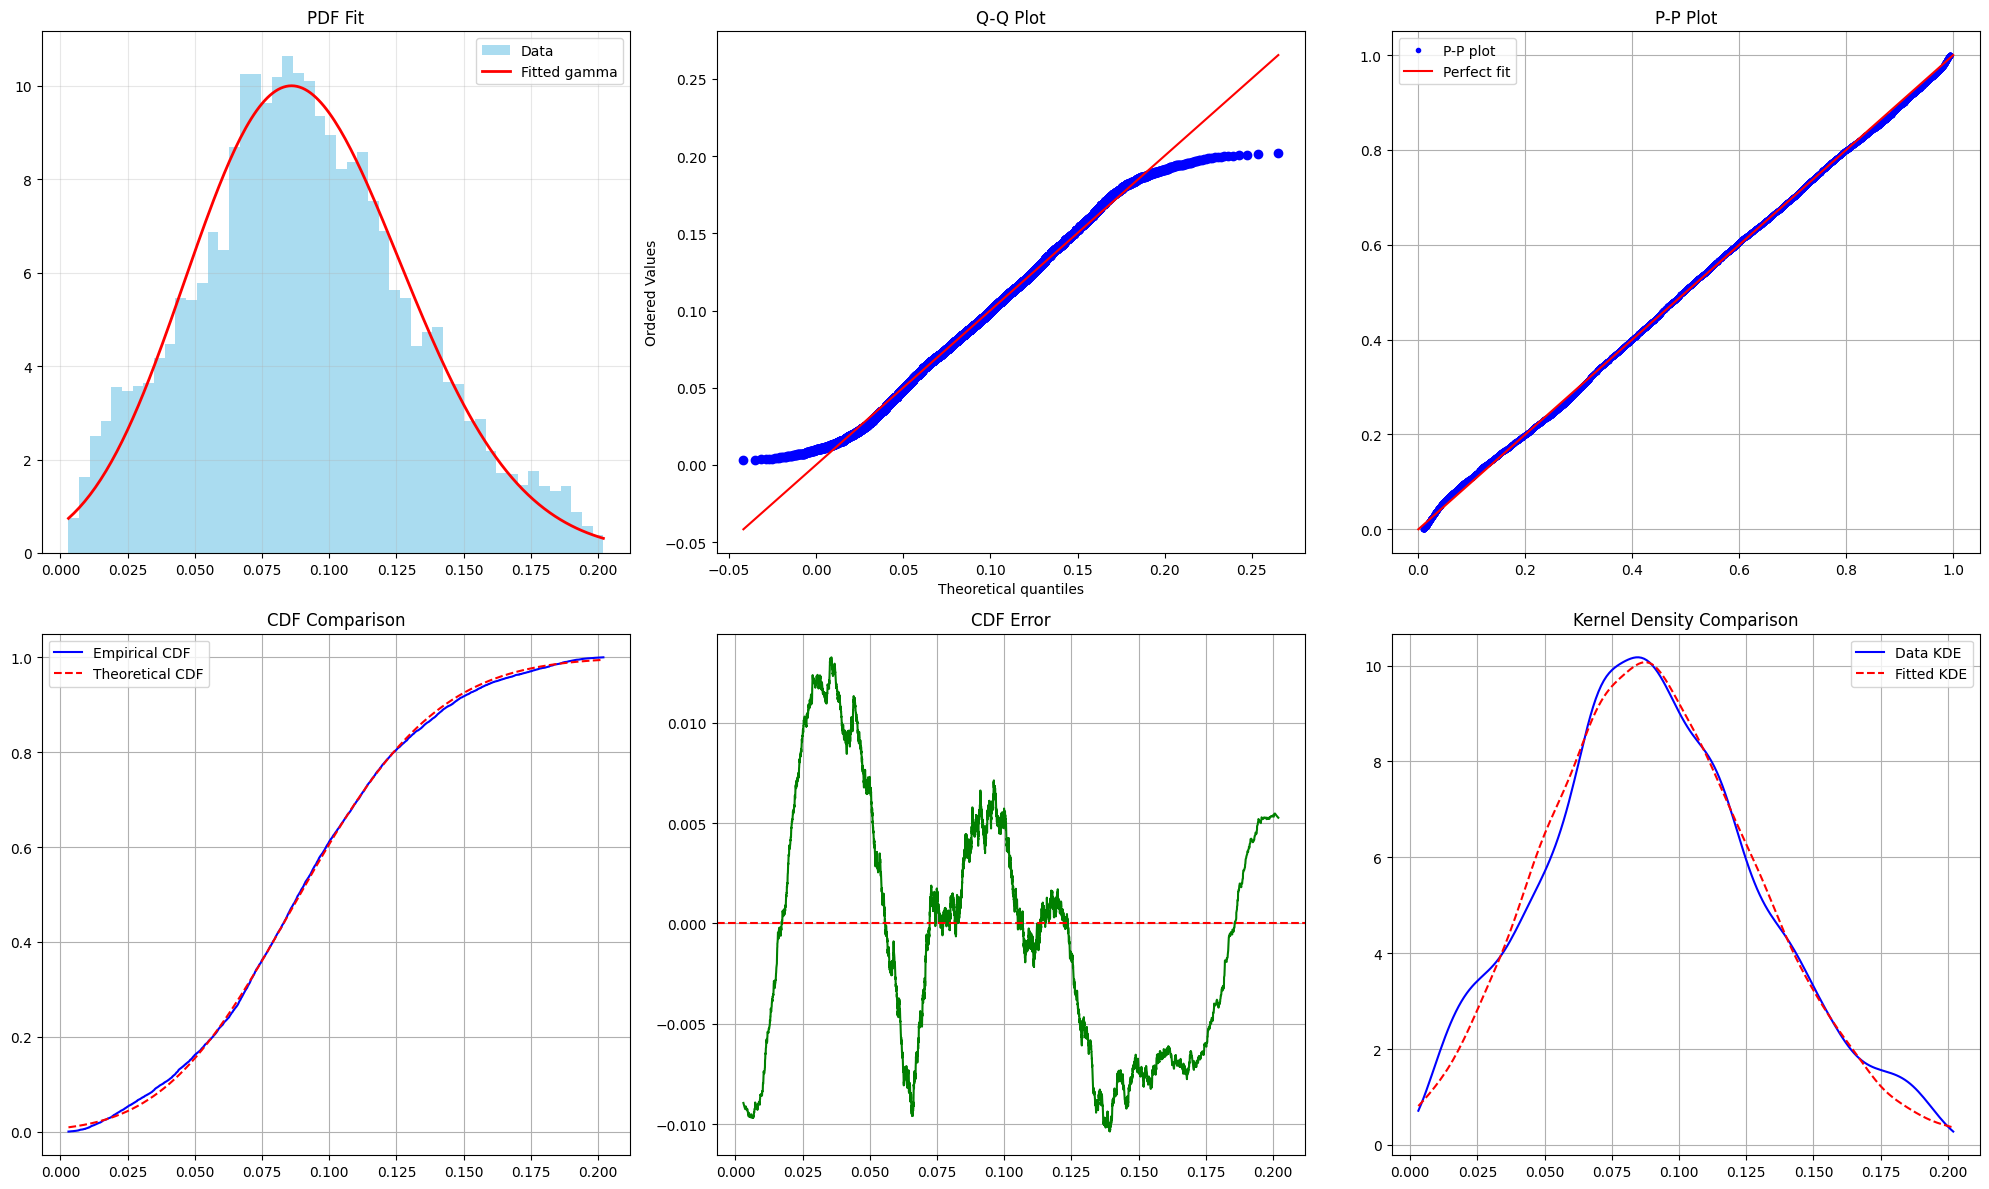

In [14]:
# Fit distributions and get results
results = fit_distribution(objective_values)

# Print detailed summary of best fits
print_distribution_summary(results, objective_values)

# Create comprehensive visualization for best fit
if len(results) > 0:
    best_fit = results.iloc[0]
    plot_distribution_analysis(objective_values, best_fit['distribution'], best_fit['parameters'])


In [ ]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

def quick_distribution_assessment(data, dist_name, params, n_bootstrap=100):
    """
    Perform quick but comprehensive assessment of distribution fit.
    
    Parameters:
    -----------
    data : array-like
        The observed data
    dist_name : str
        Name of the distribution
    params : tuple
        Parameters of the fitted distribution
    n_bootstrap : int
        Number of bootstrap samples (reduced for speed)
    """
    distribution = getattr(stats, dist_name)
    
    # 1. Quick parameter uncertainty estimation
    rng = np.random.default_rng()
    bootstrap_params = []
    for _ in range(n_bootstrap):
        sample = rng.choice(data, size=len(data)//10)  # Use only 10% of data for speed
        try:
            params_i = distribution.fit(sample)
            bootstrap_params.append(params_i)
        except:
            continue
    bootstrap_params = np.array(bootstrap_params)
    
    # 2. Local density assessment
    hist, bins = np.histogram(data, bins='auto', density=True)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    pdf = distribution.pdf(bin_centers, *params)
    relative_error = (hist - pdf) / pdf
    
    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # 1. PDF and Histogram
    axes[0,0].hist(data, bins='auto', density=True, alpha=0.7, label='Data')
    x = np.linspace(min(data), max(data), 100)
    axes[0,0].plot(x, distribution.pdf(x, *params), 'r-', label='Fitted')
    axes[0,0].set_title('PDF Fit')
    axes[0,0].legend()
    
    # 2. Q-Q Plot
    stats.probplot(data, dist=dist_name, sparams=params, plot=axes[0,1])
    axes[0,1].set_title('Q-Q Plot')
    
    # 3. Local Error
    axes[1,0].plot(bin_centers, relative_error, 'g-')
    axes[1,0].axhline(y=0, color='r', linestyle='--')
    axes[1,0].set_title('Local Relative Error')
    
    # 4. Parameter Uncertainties
    if len(bootstrap_params) > 0:
        for i in range(min(len(params), 2)):  # Plot first two parameters only
            axes[1,1].hist(bootstrap_params[:,i], bins=20, alpha=0.5, 
                         label=f'Param {i+1}')
        axes[1,1].set_title('Parameter Distributions\n(from bootstrap)')
        axes[1,1].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Quick statistics
    print("\nQuick Distribution Assessment:")
    print("=============================")
    
    # 1. Basic goodness of fit
    ks_stat, ks_pval = stats.kstest(data, dist_name, params)
    print(f"\n1. Kolmogorov-Smirnov Test:")
    print(f"   Statistic: {ks_stat:.6f}")
    print(f"   p-value: {ks_pval:.6f}")
    
    # 2. Parameter uncertainties
    if len(bootstrap_params) > 0:
        print("\n2. Parameter Uncertainties:")
        for i, param in enumerate(params):
            ci = np.percentile(bootstrap_params[:,i], [2.5, 97.5])
            print(f"   Parameter {i+1}: {param:.6f} ± {(ci[1]-ci[0])/2:.6f}")
    
    # 3. Moment comparison
    print("\n3. Moment Comparison:")
    print(f"                  Data    Fitted")
    print(f"   Mean:     {np.mean(data):8.4f} {distribution.mean(*params):8.4f}")
    print(f"   Std Dev:  {np.std(data):8.4f} {np.sqrt(distribution.var(*params)):8.4f}")
    
    # 4. Quick assessment
    mean_error = abs(np.mean(data) - distribution.mean(*params)) / np.std(data)
    max_local_error = np.max(np.abs(relative_error[~np.isinf(relative_error)]))
    
    print("\n4. Overall Assessment:")
    confidence = 100 * (1 - np.mean([
        ks_stat > 0.1,
        ks_pval < 0.05,
        mean_error > 0.1,
        max_local_error > 0.5
    ]))
    
    print(f"   Confidence in fit: {confidence:.1f}%")
    if confidence > 80:
        print("   Strong evidence supporting the distribution fit")
    elif confidence > 60:
        print("   Moderate evidence supporting the distribution fit")
    else:
        print("   Weak evidence supporting the distribution fit")
        
quick_distribution_assessment(objective_values, 'rice', (1.3018538673929319, 0.0001945896061549906, 0.05499885809250096))